In [32]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.set_option('display.max_rows', None)
plt.style.use('seaborn-colorblind')

In [33]:
#load in data
athletes = pd.read_csv(r'summer.csv')
population = pd.read_csv(r'population_total_long.csv')
countryCodes = pd.read_csv(r'dictionary.csv')

#used to remove * character from the end of strings
def removeAsterix(text):
    if re.match('\*',text[-1]):
        return text[:-1]
    else:
        return text

#prepare countryCodes do it can be used to convert 3-letter abbreviations to full country names as a dictionary
countryCodes.drop(['Population', 'GDP per Capita'], inplace = True, axis = 1)
countryCodes['Country'] = countryCodes['Country'].apply(lambda x: removeAsterix(x))
countryCodes.set_index('Code', inplace = True)
countryCodes = countryCodes.to_dict()
countryCodes = dict(ele for sub in countryCodes.values() for ele in sub.items())
countryCodes.update({'URS': 'Soviet Union', 'EUA': 'United Team of Germany', 'ROU':'Romania', 'SGP':'Singapore',
                    'SRB':'Serbia', 'TTO':'Trinidad and Tobago','BWI':'British West Indies','EUN':'Unified Team',
                    'FRG':'West Germany','GDR':'East Germany','IOP':'Independent Olympic Participants','MNE':'Montenegro',
                    'TCH':'Czechoslovakia','YUG':'Yugoslavia'})

#prepare athletes data set
athletes.dropna(subset=['Country'], inplace = True)
athletes = athletes[athletes['Year'] > 1959]
athletes = athletes.replace({"Country": countryCodes})
athletes.drop_duplicates(['Year','Event','Medal','Gender','Country'], keep='first', inplace = True)

#prepare population data set
population = population[population['Year'] % 4 == 0]
population.set_index(['Year','Country Name'], inplace = True)

#get number of medals by year and country
numMedals = athletes.groupby(['Year', 'Country']).size()

#combine medal and population data
df = pd.concat([numMedals.to_frame(), population], axis=1)
df.dropna(inplace = True)
df.reset_index(inplace = True)
df.columns = ['Year','Country','Medals','Population']
df['People per Medal'] = df['Population'] / df['Medals']

#seperate USA data
USA = df[df['Country'] == 'United States']
newDF = df[df['Country'] != 'United States']

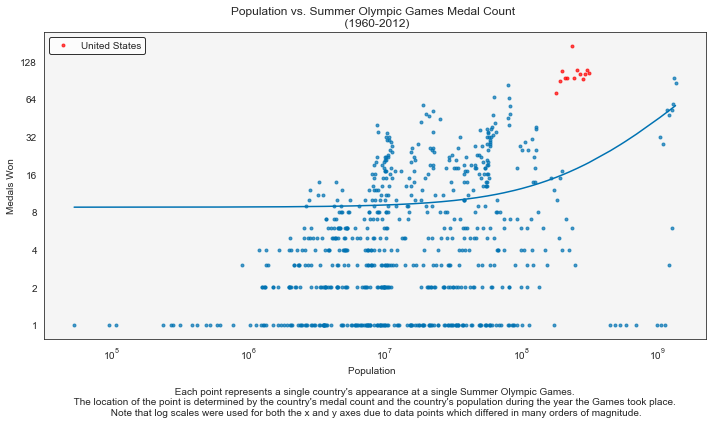

In [34]:
from matplotlib.ticker import ScalarFormatter

#initialize plot
sns.set_style('white')
plt.figure(figsize = (10,6))
ax = plt.gca()

#plot points
ax.scatter(newDF['Population'], newDF['Medals'], alpha=0.7, marker = '.')
redScatter = ax.scatter(USA['Population'], USA['Medals'] , color = 'red' , alpha = 0.7, marker = '.')

#change to log scales for easier data viewing
ax.set_yscale('log')
ax.set_xscale('log')

#change background color
ax.set_facecolor('whitesmoke')

#add legend, axes, caption, and modify tick labels
#note the caption is implmented through a sort of hack since it is technically part of the x axis label
plt.legend([redScatter],['United States'], loc = 2, frameon = True, edgecolor = 'black')
plt.xlabel('Population  \n\n Each point represents a single country\'s appearance at a single Summer Olympic Games. \n The location of the point is determined by the country\'s medal count and the country\'s population during the year the Games took place. \n Note that log scales were used for both the x and y axes due to data points which differed in many orders of magnitude.')
plt.ylabel('Medals Won')
plt.title('Population vs. Summer Olympic Games Medal Count \n (1960-2012)')
plt.yticks([1,2,4,8,16,32,64,128,256])
plt.gca().yaxis.set_major_formatter(ScalarFormatter())

#calculate and plot a simple linear regression
m, b = np.polyfit(df['Medals'], df['Population'], 1)
plt.plot(np.unique(df['Population']), np.poly1d(np.polyfit(df['Population'], df['Medals'], 1))(np.unique(df['Population'])))

#apply a loayout so all elements fit neatly and display the image
plt.gcf().tight_layout()
plt.show()
